# **🏠 부동산 실거래가**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [794]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [795]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import re
import math
from geopy.geocoders import Nominatim
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from functools import partial
import eli5
from eli5.sklearn import PermutationImportance
import optuna

#### Util Functions

In [796]:
geo_local = Nominatim(user_agent='South Korea')

# 주소 -> 경도, 위도 반환하는 함수
def get_coordinates(addr):
    try:
        geo = geo_local.geocode(addr)
        x, y = geo.longitude, geo.latitude
        return x, y
    except:
        return np.nan, np.nan

# 주어진 행과 위치 데이터의 모든 지점 간의 거리 계산 및 조건을 만족하는 지점의 개수 반환
def calculate_distances_vectorized(row, df_loc, distance, alpha=0):
    row_coords = np.radians(np.array([row[0], row[1]]))
    df_coords = np.radians(df_loc[['좌표Y', '좌표X']].values.T)
    distances = np.linalg.norm(row_coords[:, np.newaxis] - df_coords, axis=0) * 6371000  # row_coords 브로드캐스팅
    return np.sum((distances + alpha <= distance).astype(int))

# 병렬 처리
def get_number_of_object(df_main, df_object, distances, alpha=0):
    df_main_loc = df_main[['좌표Y', '좌표X']]
    df_object_loc = df_object[['좌표Y', '좌표X']]

    with ThreadPoolExecutor() as executor:
        result = list(executor.map(lambda row_train: calculate_distances_vectorized(row_train, df_object_loc, distances),
                                    tqdm(df_main_loc.itertuples(index=False),
                                        total=len(df_main_loc), desc='Building Iteration', position=1)))

    df = pd.DataFrame(result)
    return df

# 위도, 경도로 두 지점간의 거리 계산
def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = radius * c
    return distance

## 2. Data Load

#### 2.1. 데이터 로드

In [797]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../train.csv'
test_path  = '../test.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', df_train.shape, 'Test data shape : ', df_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [798]:
df_train.head(3)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500


In [799]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [800]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
df_train['is_test'] = 0
df_test['is_test'] = 1

# train과 test data 하나로 합치기
concat = pd.concat([df_train, df_test]) 
concat = concat.reset_index()

concat['is_test'].value_counts()   

0    1118822
1       9272
Name: is_test, dtype: int64

In [801]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})
concat = concat.rename(columns={'k-단지분류(아파트,주상복합등등)':'k-단지분류'})
concat = concat.rename(columns={'기타/의무/임대/임의=1/2/3/4':'기타/의무/임대/임의'})
concat = concat.rename(columns={'k-전용면적별세대현황(60㎡이하)':'k-전용면적별세대_60'})
concat = concat.rename(columns={'k-전용면적별세대현황(60㎡~85㎡이하)':'k-전용면적별세대_60_85'})
concat = concat.rename(columns={'k-85㎡~135㎡이하':'k-전용면적별세대_85_135'})
concat = concat.rename(columns={'k-135㎡초과':'k-전용면적별세대_135'})
concat = concat.rename(columns={'관리비 업로드':'관리비업로드'})

# 필요 없는 컬럼 제거
concat = concat.drop(['k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-홈페이지',
                            '고용보험관리번호', '중개사소재지', 'k-수정일자', 'k-등록일자',
                            '해제사유발생일', '등기신청일자', 'k-사용검사일-사용승인일', '단지신청일', '단지승인일',
                            ], axis=1)

# 지번주소 컬럼 추가
concat['지번주소'] = concat['시군구'] + ' ' + concat['본번'].astype('str').str.replace(r'\.0', '')
concat['지번주소'] += np.where(concat['부번'].astype('str').str.replace(r'\.0', '') != '0', '-' + concat['부번'].astype('str').str.replace(r'\.0', ''), '')

# 도로명 ' '인 경우 아파트명으로 대체
concat.loc[concat['도로명'] == ' ', '도로명'] = concat.loc[concat['도로명'] == ' ', '아파트명']

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 코드에서는 결측치가 80만개 이상인 일부 변수는 제거하고, 나머지 변수의 결측치는 대체하도록 하겠습니다.
  - 수치형 변수의 경우에는 회귀 모델에 기반하여 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

In [802]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [803]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)

# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

index                     0
시군구                       0
번지                      227
본번                       75
부번                       75
아파트명                   2136
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
거래유형                1086451
k-단지분류               877273
k-세대타입(분양형태)         876125
k-관리방식               876125
k-복도유형               876454
k-난방방식               876125
k-전체동수               877207
k-전체세대수              876125
k-건설사(시공사)           877637
k-시행사                877834
k-연면적                876125
k-주거전용면적             876170
k-관리비부과면적            876125
k-전용면적별세대_60         876170
k-전용면적별세대_60_85      876170
k-전용면적별세대_85_135     876170
k-전용면적별세대_135       1127765
경비비관리형태              877561
세대전기계약방법             885389
청소비관리형태              877751
건축면적                 876279
주차대수                 876277
기타/의무/임대/임의          876125
사용허가여부              

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

#### NaN값이 80만개 이상인 칼럼 삭제

In [804]:
# NaN값이 80만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 80만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 800000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 80만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 800000]))

* 결측치가 80만개 이하인 변수들 : ['index', '시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'target', 'is_test', '지번주소']
* 결측치가 80만개 이상인 변수들 : ['거래유형', 'k-단지분류', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대_60', 'k-전용면적별세대_60_85', 'k-전용면적별세대_85_135', 'k-전용면적별세대_135', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의', '사용허가여부', '관리비업로드', '좌표X', '좌표Y']


In [805]:
# 결측치가 80만개 이하인 변수 + 일부 컬럼들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 800000])
selected += ['좌표X', '좌표Y', 'k-복도유형', 'k-단지분류', '주차대수']
concat_select = concat[selected]

In [806]:
concat_select.isnull().sum() # target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

index           0
시군구             0
번지            227
본번             75
부번             75
아파트명         2136
전용면적            0
계약년월            0
계약일             0
층               0
건축년도            0
도로명             0
target       9272
is_test         0
지번주소            0
좌표X        876232
좌표Y        876232
k-복도유형     876454
k-단지분류     877273
주차대수       876277
dtype: int64

#### 서울시 공동주택 아파트 정보로 일부 결측치 대체

In [807]:
# 결측치 대체를 위해 서울시 공동주택 아파트 정보 load (https://data.seoul.go.kr/dataList/OA-15818/A/1/datasetView.do )
apt_path = '../apartments.csv'
df_apt = pd.read_csv(apt_path, encoding='cp949')

# '도로명주소'를 기준으로 df_train의 결측치 대체 ('아파트명'은 같은 아파트임에도 서로 일치하지 않는 항목이 많아서)
df_apt['도로명주소'] = df_apt['주소(도로명)'] + ' ' + df_apt['주소(도로상세주소)']
df_apt_unique = df_apt.drop_duplicates(subset='도로명주소')

concat_select['좌표X'] = concat_select['좌표X'].fillna(concat_select['도로명'].map(df_apt_unique.set_index('도로명주소')['좌표X'])).astype('float')
concat_select['좌표Y'] = concat_select['좌표Y'].fillna(concat_select['도로명'].map(df_apt_unique.set_index('도로명주소')['좌표Y']))

concat_select['k-단지분류'] = concat_select['k-단지분류'].fillna(concat_select['도로명'].map(df_apt_unique.set_index('도로명주소')['k-단지분류(아파트,주상복합등등)']))
concat_select['k-복도유형'] = concat_select['k-복도유형'].fillna(concat_select['도로명'].map(df_apt_unique.set_index('도로명주소')['k-복도유형']))
concat_select['주차대수'] = concat_select['주차대수'].fillna(concat_select['도로명'].map(df_apt_unique.set_index('도로명주소')['주차대수']))

concat_select.isnull().sum()

index           0
시군구             0
번지            227
본번             75
부번             75
아파트명         2136
전용면적            0
계약년월            0
계약일             0
층               0
건축년도            0
도로명             0
target       9272
is_test         0
지번주소            0
좌표X        257152
좌표Y        257152
k-복도유형     257608
k-단지분류     259137
주차대수       259357
dtype: int64

#### geopy 라이브러리로 나머지 좌표 결측치 대체

In [808]:
# '도로명'이 같은 관측치끼리 한 번만 좌표값을 가져오도록 처리
# unique_roads = df_concat_select[df_concat_select['좌표X'].isnull()]['도로명'].unique()

# for road in tqdm(unique_roads):
#     mask = (df_concat_select['도로명'] == road) & (df_concat_select['좌표X'].isnull())

#     if mask.any():
#         coordinates = get_coordinates(road)

#         # 가져온 좌표값을 결측치가 있는 관측치에 채우기
#         df_concat_select.loc[mask, ['좌표X', '좌표Y']] = coordinates

# # 좌표X, 좌표Y 결측치 대체 후 남은 결측치 확인
# df_concat_select[['좌표X', '좌표Y']].isnull().sum()

In [809]:
# # 남은 좌표X, 좌표Y 결측치는 지번주소를 사용해 가져오기
# unique_roads = df_concat_select[df_concat_select['좌표X'].isnull()]['지번주소'].unique()

# for road in tqdm(unique_roads):
#     mask = (df_concat_select['지번주소'] == road) & (df_concat_select['좌표X'].isnull())

#     if mask.any():
#         coordinates = get_coordinates(road)
#         df_concat_select.loc[mask, ['좌표X', '좌표Y']] = coordinates

# # 좌표X, 좌표Y 결측치 대체 후 남은 결측치 확인
# df_concat_select[['좌표X', '좌표Y']].isnull().sum()

In [810]:
# df_concat_select[df_concat_select['좌표X'].isnull()]['지번주소'].unique()

# df_concat_select.loc[df_concat_select['지번주소'] == '서울특별시 노원구 상계동 95-274', ['좌표X', '좌표Y']] = 127.077516, 37.664439
# df_concat_select.loc[df_concat_select['지번주소'] == '서울특별시 동대문구 이문동 257-516', ['좌표X', '좌표Y']] = 127.059407, 37.600432

# df_concat_select[['좌표X', '좌표Y']].to_csv(base_path + 'coordinates.csv', index=False)

# # 좌표X, 좌표Y 결측치 대체 후 남은 결측치 확인
# df_concat_select[['좌표X', '좌표Y']].isnull().sum()

In [811]:
# 서울시 공동주택 데이터 + geopy 라이브러리를 사용한 결측치 대체 완료 후 좌표 데이터 불러오기
df_coordinates = pd.read_csv('../coordinates.csv')
concat_select[['좌표X', '좌표Y']] = df_coordinates[['좌표X', '좌표Y']]

#### 남은 결측치 보간

In [812]:
# 지번주소 컬럼 생성으로 필요 없어진 컬럼 삭제
concat_select = concat_select.drop(['번지', '본번', '부번'], axis=1)

In [813]:
# 먼저, 수치형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
numerical_cols = []
categorical_cols = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        numerical_cols.append(column)
    else:
        categorical_cols.append(column)

print("수치형 변수:", numerical_cols)
print("범주형 변수:", categorical_cols)

수치형 변수: ['index', '전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test', '좌표X', '좌표Y', '주차대수']
범주형 변수: ['시군구', '아파트명', '도로명', '지번주소', 'k-복도유형', 'k-단지분류']


In [814]:
# 결측치가 존재하는 컬럼
cols_with_missing_vals = concat_select.columns[concat_select.isnull().any()].difference(['target'])
missing_vals_cnt = concat_select.isnull().sum()[cols_with_missing_vals]

print('결측치가 존재하는 수치형 변수:')
print(missing_vals_cnt[cols_with_missing_vals.isin(numerical_cols)])
print('결측치가 존재하는 범주형 변수:')
print(missing_vals_cnt[cols_with_missing_vals.isin(categorical_cols)])

결측치가 존재하는 수치형 변수:
주차대수    259357
dtype: int64
결측치가 존재하는 범주형 변수:
k-단지분류    259137
k-복도유형    257608
아파트명        2136
dtype: int64


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

##### 회귀 모델에 기반한 수치형 변수 결측치 대체

In [815]:
# 수치형 변수에 대한 보간
num_cols_with_missing_vals = cols_with_missing_vals[cols_with_missing_vals.isin(numerical_cols)]

for col in tqdm(num_cols_with_missing_vals):
    reg_train = concat_select[concat_select[col].notnull()].drop(['target', 'is_test', 'index'], axis=1)
    reg_test = concat_select[concat_select[col].isnull()].drop(['target', 'is_test', 'index'], axis=1)
    X_cols = reg_train.columns[(reg_train.isnull().sum() == 0) & (reg_test.isnull().sum() == 0)].tolist()

    X_reg_train = reg_train[X_cols]
    y_reg_train = reg_train[col]
    X_reg_test = reg_test[X_cols]

    # Label-Encoding
    cat_cols = X_reg_train.select_dtypes(include=['object']).columns
    label_encoders = {}
    for cat_col in cat_cols:
        lbl = LabelEncoder()

        lbl.fit(X_reg_train[cat_col].astype(str))
        X_reg_train[cat_col] = lbl.transform(X_reg_train[cat_col].astype(str))
        label_encoders[cat_col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

        for label in np.unique(X_reg_test[cat_col].astype(str)):
            if label not in lbl.classes_:
                lbl.classes_ = np.append(lbl.classes_, label)
        X_reg_test[cat_col] = lbl.transform(X_reg_test[cat_col].astype(str))

    # RandomForestRegressor를 이용해 회귀 모델로 학습
    model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
    model.fit(X_reg_train, y_reg_train)
    pred = model.predict(X_reg_test)

    concat_select.loc[reg_test.index, col] = pred

# 수치형 변수의 결측치가 보간된 모습 확인
concat_select.isnull().sum()


100%|██████████| 1/1 [00:05<00:00,  5.72s/it]


index           0
시군구             0
아파트명         2136
전용면적            0
계약년월            0
계약일             0
층               0
건축년도            0
도로명             0
target       9272
is_test         0
지번주소            0
좌표X             0
좌표Y             0
k-복도유형     257608
k-단지분류     259137
주차대수            0
dtype: int64

##### 범주형 변수 임의의 범주로 결측치 대체

In [816]:
# 범주형 변수에 대한 보간
cat_cols_with_missing_vals = cols_with_missing_vals[cols_with_missing_vals.isin(categorical_cols)]
concat_select[cat_cols_with_missing_vals] = concat_select[cat_cols_with_missing_vals].fillna('NULL')

# 결측치가 보간된 모습을 확인해봅니다.
concat_select.isnull().sum()       

index         0
시군구           0
아파트명          0
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
target     9272
is_test       0
지번주소          0
좌표X           0
좌표Y           0
k-복도유형        0
k-단지분류        0
주차대수          0
dtype: int64

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

In [817]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 17)


In [818]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
# fig = plt.figure(figsize=(7, 3))
# sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
# plt.title('전용면적 분포')
# plt.xlabel('Area')
# plt.show()

In [819]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [820]:
# target 기준 이상치 제거
# concat_select = remove_outliers_iqr(concat_select, 'target')

In [821]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
# print(concat_select.shape)

In [822]:
# concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [823]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4]).astype('int')
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:]).astype('int')

# custom validation split을 위해
concat_select['계약년월일'] = (concat_select['계약년월'].astype(str) + concat_select['계약일'].astype(str).str.zfill(2)).astype(int)

# 도로명(도로명주소)에서 도로이름만 추출
concat_select['도로'] = concat_select['도로명'].str.replace(r'\d.*$', '').str.strip()

In [824]:
concat_select.columns

Index(['index', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'target',
       'is_test', '지번주소', '좌표X', '좌표Y', 'k-복도유형', 'k-단지분류', '주차대수', '구', '동',
       '계약년', '계약월', '계약년월일', '도로'],
      dtype='object')

#### 강남여부 변수 추가

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [825]:
# 강남여부 파생변수 추가
# all = list(concat_select['구'].unique())
# gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
# gangbuk = [x for x in all if x not in gangnam]

# assert len(all) == len(gangnam) + len(gangbuk) 

# is_gangnam = []
# for x in concat_select['구'].tolist() :
#   if x in gangnam :
#     is_gangnam.append(1)
#   else :
#     is_gangnam.append(0)

# concat_select['강남여부'] = is_gangnam

#### 부촌여부, 상위아파트여부 변수 추가

In [826]:
# train 데이터 실거래가 상위 아파트 -> 청담동, 한남동, 성수동 1가
df_train.sort_values('target', ascending=False).drop_duplicates(subset='아파트명').head(10)[['시군구', '아파트명', 'target']]

,시군구,아파트명,target
224567,서울특별시 강남구 청담동,PH129,1450000
236663,서울특별시 용산구 한남동,파르크한남,1350000
233420,서울특별시 성동구 성수동1가,아크로서울포레스트,1300000
236258,서울특별시 용산구 한남동,한남더힐,1100000
445597,서울특별시 강남구 삼성동,아이파크,1053000
288739,서울특별시 용산구 한남동,르가든더메인한남,970000
221948,서울특별시 용산구 한남동,나인원한남,945000
203591,서울특별시 강남구 청담동,상지리츠빌카일룸2차,900000
233399,서울특별시 성동구 성수동1가,갤러리아포레,880000
223824,서울특별시 강남구 도곡동,타워팰리스1,870000


In [827]:
# 부촌여부 파생변수 추가
all = list(concat_select['동'].unique())
rich = ['한남동', '성수동1가', '청담동']
rest = [x for x in all if x not in rich]

assert len(all) == len(rich) + len(rest) 

is_rich = []
for x in concat_select['동'].tolist() :
  if x in rich :
    is_rich.append(1)
  else :
    is_rich.append(0)

concat_select['부촌여부'] = is_rich

In [828]:
# top10 아파트 여부 파생변수 추가
all = list(concat_select['아파트명'].unique())
top10 = concat_select.sort_values(by='target', ascending=False)['아파트명'].unique()[:10]
rest = [x for x in all if x not in top10]

assert len(all) == len(top10) + len(rest) 

is_top10 = []
for x in concat_select['아파트명'].tolist() :
  if x in top10 :
    is_top10.append(1)
  else :
    is_top10.append(0)

concat_select['상위아파트여부'] = is_top10

#### 동별 상위 아파트와의 거리 변수 추가

In [829]:
# 상위 아파트 도로명 가져오기
# top_addr_list = concat_select.sort_values('target', ascending=False).drop_duplicates(subset='아파트명').head(20)[['도로명', '동']].values

# 상위 아파트의 위경도 정보 가져오기
# top_coords = {}
# for addr, dong in top_addr_list:
#     x, y = get_coordinates(addr)
#     if dong not in top_coords:
#         top_coords[dong] = (x, y) 

# 상위 아파트가 속한 동을 기준으로 병합
# top_apt_coords = pd.DataFrame([{'동': k, 'top_좌표X': v[0], 'top_좌표Y': v[1]} for k, v in top_coords.items()])
# top_apt_coords.to_csv('../top_apt_coords.csv', index=False)

top_apt_coords = pd.read_csv('../top_apt_coords.csv')
concat_select = pd.merge(concat_select, top_apt_coords, how="left", on="동")

# 상위 아파트와의 거리 계산
concat_select['top아파트거리'] = concat_select.apply(lambda row: haversine_distance(row["좌표Y"], row["좌표X"], row["top_좌표Y"], row["top_좌표X"]), axis=1)
concat_select['top아파트거리'] = concat_select['top아파트거리'].fillna(500)
del concat_select['top_좌표X'], concat_select['top_좌표Y']

In [830]:
top_apt_coords

,동,top_좌표X,top_좌표Y
0,청담동,127.050787,37.525444
1,한남동,127.011944,37.535432
2,성수동1가,127.044176,37.544501
3,삼성동,127.063203,37.508530
4,도곡동,127.055250,37.488803


#### 신축여부 변수 추가

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [831]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2010년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
# concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

In [832]:
# 따라서 2018년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
# concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2018 else 0)
# concat_select.head(1)

#### 아파트 브랜드명 변수 추가

In [833]:
brand_names = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한', '힐스테이트', '아이파크', 
             '래미안', 'SK|에스케이', '데시앙', '그레이스', '양지', '쌍용', '현대', '한신', '삼성', 
             '대우', '신동아', '두산', '주공', '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', 
             '삼익', '대림', '코오롱', '파크리오', '엘지', '성원', '잠실', '동궁리치웰', '동성']

concat_select['브랜드명'] = 'others'
for brand in brand_names:
    concat_select.loc[concat_select['아파트명'].str.contains(brand, case=False, regex=True), '브랜드명'] = brand

#### 건물연식 변수 추가

In [834]:
# 계약년 기준 건물 연식
concat_select['건물연식'] = concat_select['계약년'] -  concat_select['건축년도']

#### 지역구별 대장 아파트 기준 거리 변수 추가

In [835]:
# 지역구별 대장 아파트들을 입력합니다.
lead_house = {
    "강서구" : (37.56520754904415, 126.82349451366355),
    "관악구" : (37.47800896704934, 126.94178722423047),
    "강남구" : (37.530594054209146, 127.0262701317293),
    "강동구" : (37.557175745977375, 127.16359581113558),
    "광진구" : (37.543083184171, 127.0998363490422),
    "구로구" : (37.51045944660659, 126.88687199829572),
    "금천구" : (37.459818907487936, 126.89741481874103),
    "노원구" : (37.63952738902813, 127.07234254197617),
    "도봉구" : (37.65775043994647, 127.04345013224447),
    "동대문구" : (37.57760781415707, 127.05375628992316),
    "동작구" : (37.509881249641495, 126.9618159122961),
    "마포구" : (37.54341664563958, 126.93601641235335),
    "서대문구" : (37.55808950436837, 126.9559315685538),
    "서초구" : (37.50625410912666, 126.99846468032919),
    "성동구" : (37.53870643389788, 127.04496220606433),
    "성북구" : (37.61158435092128, 127.02699796439015),
    "송파구" : (37.512817775046074, 127.08340371063358),
    "양천구" : (37.526754982736556, 126.86618704123521),
    "영등포구" : (37.52071403351804, 126.93668907644046),
    "용산구" : (37.521223570097305, 126.97345317787784),
    "은평구" : (37.60181702377437, 126.9362806808709),
    "종로구" : (37.56856915384472, 126.96687674967252),
    "중구" : (37.5544678205846, 126.9634879236162),
    "중랑구" : (37.58171824083332, 127.08183326205129),
    "강북구" : (37.61186335979484, 127.02822407466175)
}

# 대장 아파트의 위경도 데이터프레임을 구성합니다.
lead_house_data = pd.DataFrame([{'구': k, '대장_좌표X': v[1], '대장_좌표Y': v[0]} for k, v in lead_house.items()])
# 데이터프레임간 결합을 합니다.
concat_select = pd.merge(concat_select, lead_house_data, how="left", on="구")
# haversine_distance 함수를 이용해 대장아파트와의 거리를 계산하고, 새롭게 컬럼을 구성합니다.
concat_select['대장아파트거리'] = concat_select.apply(lambda row: haversine_distance(row["좌표Y"], row["좌표X"], row["대장_좌표Y"], row["대장_좌표X"]), axis=1)
del concat_select['대장_좌표X']; del concat_select['대장_좌표Y']

#### 인근 지하철역 개수 변수 추가

In [836]:
# subway_path  = '../subway_feature.csv'
# df_subway = pd.read_csv(subway_path)
# df_subway.rename(columns={'위도':'좌표Y', '경도':'좌표X'}, inplace=True)

# df_subway_count = get_number_of_object(concat_select, df_subway, 500)
# df_subway_count.columns = ['500m이내 지하철역 개수']

# df_subway_count.to_csv('../subway_counts.csv', index=False)

df_subway_count = pd.read_csv('../subway_counts.csv')
concat_select['인근지하철역개수'] = df_subway_count['500m이내 지하철역 개수']
concat_select['인근지하철역개수'].value_counts()

0    621958
1    403491
2     87349
3      9020
4      4341
5      1371
6       564
Name: 인근지하철역개수, dtype: int64

#### 일부 범주형 변수(도로명, 도로, 동)별 실거래가 평균 순위 변수 추가 = 타겟 인코딩

In [837]:
# 도로명별 '실거래가'의 평균을 계산하여 순위를 매김
road_addr_ranking = concat_select.groupby('도로명')['target'].mean().reset_index()
# road_addr_ranking = concat_select.query('계약년월 > 202001').groupby('도로명')['target'].mean().reset_index()

# target이 모두 null인(train 데이터에 없는) 도로명은 도로 이름별 실거래가 평균으로 처리
target_null_roads = road_addr_ranking.loc[road_addr_ranking['target'].isnull(), '도로명'].tolist()
for road in target_null_roads:
    road_name = re.sub(r'\d.*$', '', road).strip()
    target_mean = concat_select[concat_select['도로'] == road_name]['target'].mean()
    # target_mean = concat_select.query('계약년월 > 202001')[concat_select['도로'] == road_name]['target'].mean()
    road_addr_ranking.loc[road_addr_ranking['도로명'] == road, 'target'] = target_mean
# 도로 이름도 없는 경우 동별 실거래가 평균으로 처리
if road_addr_ranking[road_addr_ranking['target'].isnull()].shape[0] > 0:
    for road in road_addr_ranking.loc[road_addr_ranking['target'].isnull(), '도로명'].tolist():
        dong_series = concat_select[concat_select['도로명'] == road]['동']
        unique_dongs = dong_series.unique()
        for dong in unique_dongs:
            dong_mean = concat_select[concat_select['동'] == dong]['target'].mean()
            # dong_mean = concat_select.query('계약년월 > 202001')[concat_select['동'] == dong]['target'].mean()
            road_addr_ranking.loc[road_addr_ranking['도로명'] == road, 'target'] = dong_mean
        
road_addr_ranking = road_addr_ranking.sort_values('target', ascending=False).reset_index()
road_addr_ranking['도로명_실거래가순위'] = range(1, len(road_addr_ranking) + 1)
road_addr_ranking = road_addr_ranking.drop(['target', 'index'], axis=1)

concat_select = pd.merge(concat_select, road_addr_ranking, on='도로명', how="left")
concat_select[['도로명', '도로명_실거래가순위']]

,도로명,도로명_실거래가순위
0,언주로 3,927
1,언주로 3,927
2,언주로 3,927
3,언주로 3,927
4,언주로 3,927
...,...,...
1128089,신내역로1길 85,2695
1128090,신내역로1길 85,2695
1128091,신내역로1길 85,2695
1128092,신내역로1길 85,2695


In [838]:
# 도로별 '실거래가'의 평균을 계산하여 순위를 매김
road_addr_ranking = concat_select.groupby('도로')['target'].mean().reset_index()
# target이 모두 null인(train 데이터에 없는) 도로 이름은 해당 동별 실거래가 평균으로 처리
if road_addr_ranking[road_addr_ranking['target'].isnull()].shape[0] > 0:
    for road in road_addr_ranking.loc[road_addr_ranking['target'].isnull(), '도로'].tolist():
        dong_series = concat_select[concat_select['도로'] == road]['동']
        unique_dongs = dong_series.unique()
        for dong in unique_dongs:
            dong_mean = concat_select[concat_select['동'] == dong]['target'].mean()
            road_addr_ranking.loc[road_addr_ranking['도로'] == road, 'target'] = dong_mean

road_addr_ranking = road_addr_ranking.sort_values('target', ascending=False).reset_index()
road_addr_ranking['도로_실거래가순위'] = range(1, len(road_addr_ranking) + 1)
road_addr_ranking = road_addr_ranking.drop(['target', 'index'], axis=1)

concat_select = pd.merge(concat_select, road_addr_ranking, on='도로', how="left")
concat_select[['도로', '도로_실거래가순위']]

,도로,도로_실거래가순위
0,언주로,35
1,언주로,35
2,언주로,35
3,언주로,35
4,언주로,35
...,...,...
1128089,신내역로,274
1128090,신내역로,274
1128091,신내역로,274
1128092,신내역로,274


In [839]:
# 동별 '실거래가'의 평균을 계산하여 순위를 매김
road_addr_ranking = concat_select.groupby('동')['target'].mean().sort_values(ascending=False).reset_index()
road_addr_ranking['동_실거래가순위'] = range(1, len(road_addr_ranking) + 1)
road_addr_ranking = road_addr_ranking.drop(['target'], axis=1)

concat_select = pd.merge(concat_select, road_addr_ranking, on='동', how="left")
concat_select[['동', '동_실거래가순위']]

,동,동_실거래가순위
0,개포동,48
1,개포동,48
2,개포동,48
3,개포동,48
4,개포동,48
...,...,...
1128089,신내동,280
1128090,신내동,280
1128091,신내동,280
1128092,신내동,280


#### 실거래가 높은 데이터 업샘플링

In [840]:
# 상대적으로 수가 적은 높은 실거래가의 데이터를 복사하여 넣어줌
df_high_cases = concat_select[concat_select['target'] >= 1300000]
concat_select = pd.concat([concat_select, df_high_cases])
concat_select = pd.concat([concat_select, df_high_cases])
# concat_select = pd.concat([concat_select, df_high_cases])

# df_high_cases2 = concat_select[concat_select['target'] >= 1000000 & (concat_select['target'] < 1300000)]
# concat_select = pd.concat([concat_select, df_high_cases2])
# concat_select = pd.concat([concat_select, df_high_cases2])

In [841]:
concat_select.shape

(1128100, 32)

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [842]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
# dt_train = concat_select.query('is_test==0').set_index('index').rename_axis(None)
# dt_test = concat_select.query('is_test==1').set_index('index').rename_axis(None)

dt_train = concat_select.query('is_test==0').reset_index()
dt_test = concat_select.query('is_test==1').reset_index()

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118828, 32) (9272, 32)


In [843]:
# 사용할 컬럼만 추출
final_cols = ['도로명_실거래가순위', '전용면적', 'k-복도유형', 'k-단지분류', '계약년', 
                  '계약월', '동_실거래가순위', '좌표X', '좌표Y', '건축년도', 
                  '부촌여부', '상위아파트여부', '대장아파트거리', '도로_실거래가순위', '구', 
                  '주차대수', '인근지하철역개수', '브랜드명', '건물연식', '계약년월일', 
                  'top아파트거리', 'target']

dt_train = dt_train[final_cols]
dt_test = dt_test[final_cols]

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

In [844]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
numerical_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        numerical_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("수치형 변수:", numerical_columns_v2)
print("범주형 변수:", categorical_columns_v2)

수치형 변수: ['도로명_실거래가순위', '전용면적', '계약년', '계약월', '동_실거래가순위', '좌표X', '좌표Y', '건축년도', '부촌여부', '상위아파트여부', '대장아파트거리', '도로_실거래가순위', '주차대수', '인근지하철역개수', '건물연식', '계약년월일', 'top아파트거리', 'target']
범주형 변수: ['k-복도유형', 'k-단지분류', '구', '브랜드명']


In [845]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


In [846]:
dt_train.head(1) # 레이블인코딩이 된 모습입니다.

,도로명_실거래가순위,전용면적,k-복도유형,k-단지분류,계약년,계약월,동_실거래가순위,좌표X,좌표Y,건축년도,...,대장아파트거리,도로_실거래가순위,구,주차대수,인근지하철역개수,브랜드명,건물연식,계약년월일,top아파트거리,target
0,927,79.97,1,3,2017,12,48,127.05721,37.476763,1987,...,6.578607,35,0,262.0,0,23,30,20171208,500.0,124000.0


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 LGBMRegressor를 이용하겠습니다.
- Train과 Valid dataset을 계약년월일 기준 8:2의 비율로 `holdout` 방법을 사용해 분할하겠습니다.

In [847]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [848]:
def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x.iloc[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x.iloc[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid

# k-fold cross-validation을 통한 모델 평가 함수
def evaluate(data_x, data_y, model, random_state=42, n_splits=5, test_x=None):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
  
    oof_y = np.zeros(len(data_x)) 
    feature_importances = np.zeros((len(data_x.columns), n_splits))

    if test_x is not None:
        test_y = np.zeros((len(test_x), n_splits))
        
    for i, (train_index, valid_index) in enumerate(kf.split(data_x, data_y)):
        train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)
        model.fit(train_x, train_y)
            
        oof_y[valid_index] = model.predict(valid_x) # out-of-fold 예측값  
        feature_importances[:, i] = model.feature_importances_
      
        if test_x is not None:
            test_y[:, i] = model.predict(test_x)
        
        print(f'{i}th-fold Validation Score : ', mean_squared_error(valid_y, oof_y[valid_index], squared=False))

    # out-of-fold 예측값에 대한 RMSE score 계산
    score = mean_squared_error(data_y, oof_y, squared=False)
    print('OOF RMSE Score : ', score)
    
    return (oof_y, np.mean(test_y, axis=1), np.mean(feature_importances, axis=1)) if test_x is not None else (oof_y, np.mean(feature_importances, axis=1))

In [849]:
# Target과 독립변수들을 분리해줍니다.
X_train_all = dt_train.drop(['target', '계약년월일'], axis=1)
y_train_all = dt_train['target']

# Custom validation split - 최근 20% 데이터를 validation set으로 나눔
dt_train = dt_train.sort_values('계약년월일')
cut = int(len(dt_train)*0.8)
train_split = dt_train[:cut]
valid_split = dt_train[cut:]

X_train = train_split.drop(['target', '계약년월일'], axis=1)
y_train = train_split['target']
X_val = valid_split.drop(['target', '계약년월일'], axis=1)
y_val = valid_split['target']

# LGBM 파라미터 설정
lgb_params = {
            'n_estimators': 2048,          
            'force_col_wise': True
            }

model = LGBMRegressor(**lgb_params)

In [850]:
# 모델 훈련 및 평가 후 oof 예측값 가져오기
# oof_pred, feature_importances = evaluate(X_train_all.copy(), y_train_all.copy(), model) 

# 모델 학습 및 평가
model.fit(X_train, y_train)
pred = model.predict(X_val)

# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'Validation RMSE: {mean_squared_error(y_val, pred, squared=False)}')


# 29308.493311434926 | 13162.652210251767
# upsampled 3: 29715.43992297235 | 13174.892746701182
# upsampled 2: 29521.1633960825 | 13105.164173905705

[LightGBM] [Info] Total Bins 2415
[LightGBM] [Info] Number of data points in the train set: 895062, number of used features: 20
[LightGBM] [Info] Start training from score 49868.185481
Validation RMSE: 29521.1633960825


- 변수 중요도도 확인해보도록 하겠습니다.

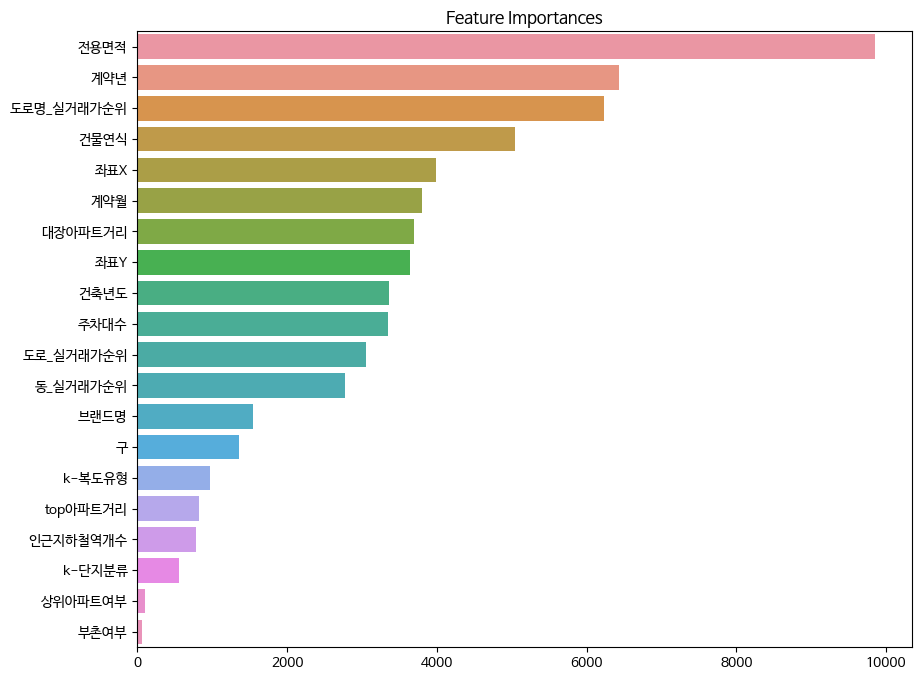

In [851]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [852]:
importances.tail(10)

도로_실거래가순위    3048
동_실거래가순위     2780
브랜드명         1542
구            1353
k-복도유형        964
top아파트거리      821
인근지하철역개수      784
k-단지분류        563
상위아파트여부       106
부촌여부           61
dtype: int32

In [853]:
# 전체 train 데이터로 학습된 모델을 저장
model.fit(X_train_all, y_train_all)
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

[LightGBM] [Info] Total Bins 2429
[LightGBM] [Info] Number of data points in the train set: 1118828, number of used features: 20
[LightGBM] [Info] Start training from score 57998.550253


### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [854]:
# # Permutation importance 방법을 변수 선택에 이용해보겠습니다.
# perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
#                              scoring = 'neg_mean_squared_error',        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
#                              random_state = 42,
#                              n_iter=3).fit(X_val, y_val)
# eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [855]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# SE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)    
X_val_sort.head(10)

,도로명_실거래가순위,전용면적,k-복도유형,k-단지분류,계약년,계약월,동_실거래가순위,좌표X,좌표Y,건축년도,...,도로_실거래가순위,구,주차대수,인근지하철역개수,브랜드명,건물연식,top아파트거리,target,pred,error
236663,1,268.670,0,0,2022,4,9,127.010279,37.532642,2020,...,4,20,476.0,1,1,2,0.343202,1350000.0,492359.192769,7.355478e+11
1118827,1,268.670,0,0,2022,4,9,127.010279,37.532642,2020,...,4,20,476.0,1,1,2,0.343202,1350000.0,492359.192769,7.355478e+11
1118824,1,268.670,0,0,2022,4,9,127.010279,37.532642,2020,...,4,20,476.0,1,1,2,0.343202,1350000.0,492359.192769,7.355478e+11
224567,2,273.960,0,0,2022,4,15,127.052217,37.526214,2020,...,6,0,223.4,0,1,2,0.152435,1450000.0,595920.206388,7.294523e+11
1118825,2,273.960,0,0,2022,4,15,127.052217,37.526214,2020,...,6,0,223.4,0,1,2,0.152435,1450000.0,595920.206388,7.294523e+11
1118822,2,273.960,0,0,2022,4,15,127.052217,37.526214,2020,...,6,0,223.4,0,1,2,0.152435,1450000.0,595920.206388,7.294523e+11
1118823,8,264.546,1,3,2022,9,49,127.043853,37.544798,2020,...,55,15,720.0,2,1,2,0.043613,1300000.0,547723.928445,5.659193e+11
233420,8,264.546,1,3,2022,9,49,127.043853,37.544798,2020,...,55,15,720.0,2,1,2,0.043613,1300000.0,547723.928445,5.659193e+11
1118826,8,264.546,1,3,2022,9,49,127.043853,37.544798,2020,...,55,15,720.0,2,1,2,0.043613,1300000.0,547723.928445,5.659193e+11
236662,3,268.950,0,0,2021,12,9,127.010279,37.532642,2020,...,4,20,476.0,1,1,1,0.343202,1200000.0,510708.896941,4.751222e+11


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [856]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

display(error_top100.head(1))
display(best_top100.head(1)) 

,도로명_실거래가순위,전용면적,k-복도유형,k-단지분류,계약년,계약월,동_실거래가순위,좌표X,좌표Y,건축년도,...,도로_실거래가순위,구,주차대수,인근지하철역개수,브랜드명,건물연식,top아파트거리,target,pred,error
236663,1,268.67,NULL,NULL,2022,4,9,127.010279,37.532642,2020,...,4,용산구,476.0,1,others,2,0.343202,1350000.0,492359.192769,7.355478e+11


,도로명_실거래가순위,전용면적,k-복도유형,k-단지분류,계약년,계약월,동_실거래가순위,좌표X,좌표Y,건축년도,...,도로_실거래가순위,구,주차대수,인근지하철역개수,브랜드명,건물연식,top아파트거리,target,pred,error
383673,6977,83.04,계단식,아파트,2019,12,231,126.905346,37.602388,1992,...,514,은평구,180.0,0,others,27,500.0,35200.0,35193.881537,37.435592


- 이제 분포를 비교해보도록 하겠습니다.

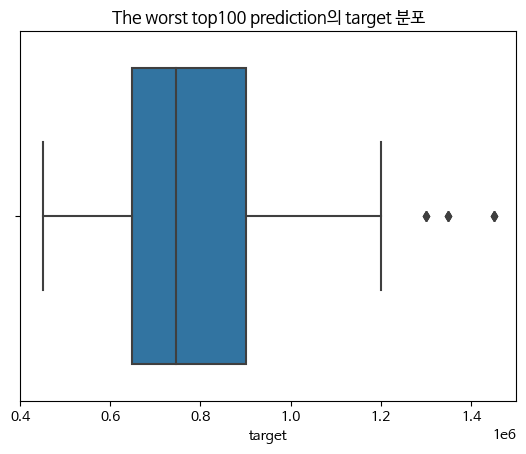

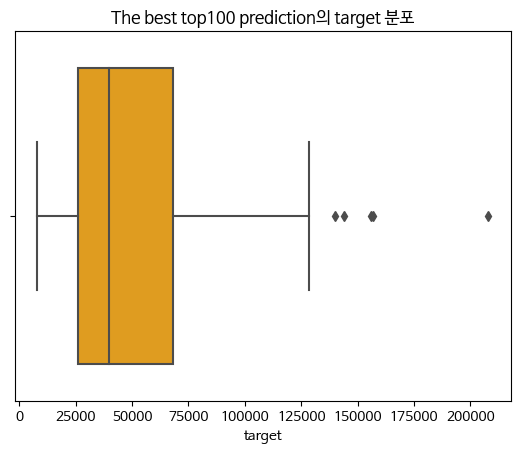

In [857]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

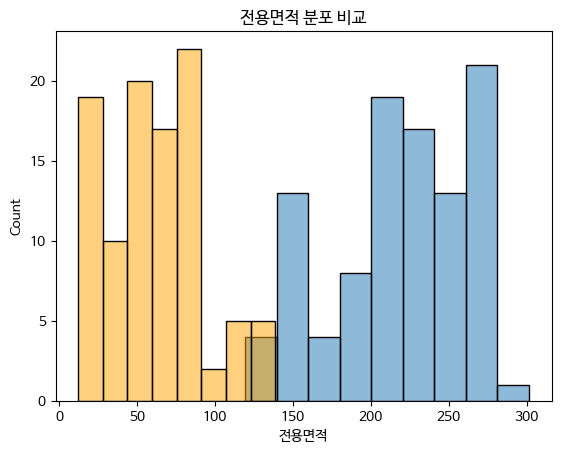

In [858]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [859]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,도로명_실거래가순위,전용면적,k-복도유형,k-단지분류,계약년,계약월,동_실거래가순위,좌표X,좌표Y,건축년도,...,대장아파트거리,도로_실거래가순위,구,주차대수,인근지하철역개수,브랜드명,건물연식,계약년월일,top아파트거리,target
0,927,79.9700,1,3,2023,7,48,127.057210,37.476763,1987,...,6.578607,35,0,262.0,0,23,36,20230726,500.0,NaN
1,1127,108.2017,1,3,2023,8,48,127.056394,37.484892,2021,...,5.734605,77,0,305.0,1,6,2,20230815,500.0,NaN


In [860]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [861]:
%%time
X_test = dt_test.drop(['target', '계약년월일'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 707 ms, sys: 0 ns, total: 707 ms
Wall time: 90 ms


In [862]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([199429.45733093, 255164.90514326, 334715.53899059, ...,
        78383.87191384,  68958.49063921,  68599.65005505])

## 7. Output File Save

In [863]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)